# Guiding questions

In which fields does the international student population overtake the domestic student population?

How important a role do international students play in our graduate programs?

Are students making compromises in academic choices in order to receive better chances of getting work visa?

In [7]:
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [8]:
df = pd.read_csv('../data/GSS_Columbia_Detailed.csv', header=4, index_col=False, thousands=',')
df.columns = [
    'Year', 'Institution Name', 'Detailed Fields', 'Citizenship', 'Count'
]
df = df.drop('Institution Name', 1) # We assume all data describes Columbia
df = df[1:-3] # Drop first row (total) annd last 3 rows (footnotes)

# Re-structure dataframe into a tree
d = defaultdict(lambda: defaultdict(dict))
for _, row in df.iterrows():
    year = int(row['Year'])
    field = row['Detailed Fields']
    citizenship = row['Citizenship']
    d[year][field][citizenship] = row['Count']

ufields = df['Detailed Fields'].unique()

In [9]:
DOM_COL_NAME = 'U.S. citizens and permanent residents (non-U.S. citizens holding green cards)'
INT_COL_NAME = 'Foreign nationals'

DOM_LABEL = 'U.S. citizens & permanent residents'
INT_LABEL = INT_COL_NAME

In [10]:
years = np.arange(1994, 2017)

In [11]:
def sumLists(a, b):
    return [(a[i] or 0) + (b[i] or 0) for i in range(len(a))]

yearTotals = [0 for _ in range(len(years))]
fieldCounts = {}
for f in ufields:
    fieldCounts[f] = [d[year][f].get(INT_COL_NAME, None) for year in years]
    yearTotals = sumLists(yearTotals, fieldCounts[f])

In [52]:
selectedFields = [
    'Statistics', 
    'Industrial and manufacturing engineering',
    'Computer sciences',
    'Civil engineering',
    'Electrical engineering',
    'Engineering science, mechanics, and physics',
    'Mechanical engineering',
    'Mathematics and applied mathematics',
    'Economics (except agricultural)',
    'Chemistry',
    'Physics',
    'Biology',
    'Sociology',
    'Nutrition'
]

In [53]:
from scipy.interpolate import interp1d
from matplotlib import cm

In [81]:
def plotProportion(ax, field, xaxis=False, color='black'):
    where = []
    counts = []
    for y in range(len(years)):
        c = fieldCounts[field][y]
        counts.append((c or -1) / yearTotals[y])
        where.append(c is not None)

    spacedYears = np.linspace(years[0], years[-1], 460)
    f = interp1d(years, counts, kind='quadratic')
    smoothCounts=f(spacedYears)
    
    spacedWhere = sum(([w] * 20 for w in where), [])

    ax.fill_between(spacedYears, 0, smoothCounts, where=spacedWhere, color=color)
    
    smoothCounts = [smoothCounts[i] if spacedWhere[i] else None for i in range(len(smoothCounts))]
    ax.plot(spacedYears, smoothCounts, color='black')
    ax.set_title(field, x=.97, y=0.25, loc='left')

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_visible(False)

    ax.set_ylim(bottom=0)
    
    if xaxis:
        ax.xaxis.set_visible(False)

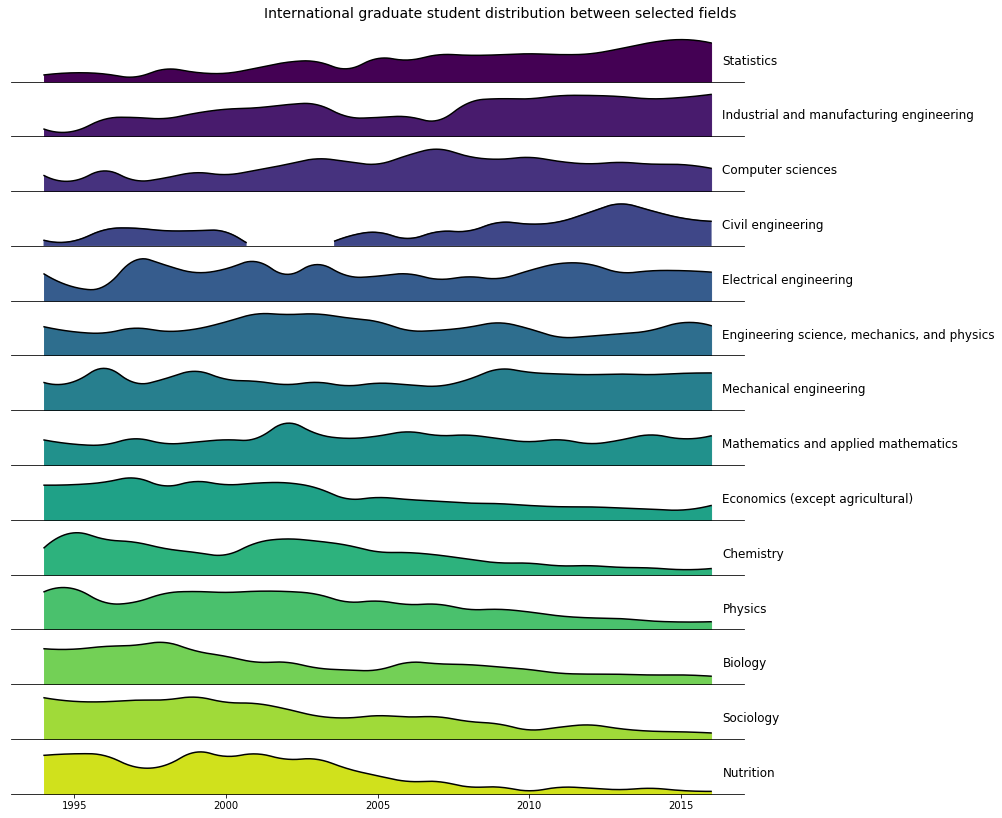

In [82]:
fig, axarr = plt.subplots(len(selectedFields), 1, sharex=True, figsize=(14, 12))

for i in range(len(selectedFields)):
    plotProportion(axarr[i], selectedFields[i], xaxis=(i != len(selectedFields) - 1), color=cm.viridis(i / len(selectedFields)))

fig.text(0.5, 0.96, 'International graduate student distribution between selected fields', ha='center', fontsize=14)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.savefig('student_distribution.png')

## Findings